Project 2 is created to find out whether a different approach in data cleaning works better for the chosen ML algorithm, XGBoost. 

Steps: 
1. Download data set
2. Make ID column the name of the rows
3. Delete columns with NaN data present
4. Apply Ordinal Encoding to deal with categorical data
5. Apply log transformation to turn the data into normal distribution
6. Calculate MI scores
7. Create new features
8. Split the data into training and validation sets
9. Apply scaling
10. Apply XGBoost algorithm
11. Apply GridSearch algorithm to tune the hyperparameters

In [11]:
import pandas as pd
train_set = "/Users/serraus/Desktop/house-prices-advanced-regression-techniques/train.csv"
training_data = pd.read_csv(train_set)

In [12]:
training_data.set_index("Id", inplace=True)

In [ ]:
from function_sheet import delete_columns
delete_columns(training_data)
print(training_data)

In [ ]:
from function_sheet import ordinal_encoder
encoded_training_data = ordinal_encoder(training_data)
print(encoded_training_data)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

log_transformation = np.log(encoded_training_data + 1)  # Adding 1 to handle zero values

log_transformed_training_data = pd.DataFrame(log_transformation, columns=encoded_training_data.columns)
print(log_transformed_training_data)

In [38]:
from function_sheet import mi_scores
x = log_transformed_training_data
y = log_transformed_training_data["SalePrice"]
mi = mi_scores(x, y)
mi.head(10)

SalePrice       5.625716
TotalSF         0.680127
OverallQual     0.573206
Neighborhood    0.511897
GrLivArea       0.477777
GarageCars      0.364512
YearBuilt       0.362289
TotalBsmtSF     0.346382
GarageArea      0.336946
ExterQual       0.336362
dtype: float64

In [19]:
from function_sheet import new_features
new_training_data_features = new_features(log_transformed_training_data)
print(new_training_data_features)

      AgeHouse    TotalSF  HasPool
Id                                
1     0.002492  20.257977        0
2     0.015559  14.282490        0
3     0.003490  20.415959        0
4     0.046401  20.127741        0
5     0.003990  21.048414        0
...        ...        ...      ...
1456  0.003992  20.265239        0
1457  0.016040  14.978718        0
1458  0.034914  21.181113        0
1459  0.030290  13.967580        0
1460  0.021636  14.272966        0

[1460 rows x 3 columns]


In [20]:
new_mi = mi_scores(x, y)
new_mi.head(20)

SalePrice       5.618177
TotalSF         0.704661
OverallQual     0.563357
Neighborhood    0.511352
GrLivArea       0.478291
GarageCars      0.369781
YearBuilt       0.361298
TotalBsmtSF     0.344872
GarageArea      0.336872
ExterQual       0.332089
KitchenQual     0.329450
AgeHouse        0.328601
1stFlrSF        0.302648
MSSubClass      0.273891
FullBath        0.270397
YearRemodAdd    0.237403
TotRmsAbvGrd    0.214365
2ndFlrSF        0.203994
LotArea         0.199820
Foundation      0.192036
dtype: float64

In [21]:
new_mi.tail(11)

LandSlope     0.003887
RoofMatl      0.003290
3SsnPorch     0.002357
YrSold        0.002045
Utilities     0.001026
HasPool       0.000379
PoolArea      0.000000
MoSold        0.000000
Condition2    0.000000
Street        0.000000
Functional    0.000000
dtype: float64

Low scored ones not removed

In [ ]:
X_2 = log_transformed_training_data.drop("SalePrice", axis = 1)
y_2 = log_transformed_training_data.SalePrice
print(X_2, y_2)

In [40]:
#Splitting the data into train/validation sets
from sklearn.model_selection import train_test_split
x_train_2, x_valid_2, y_train_2, y_valid_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42) 
#test size means that the data will be splitted as 80% training 20% validation set
#setting random state into a fixed number ensures the same result is obtained when the code is run again


In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train_2)
x_valid = scaler.transform(x_valid_2)


In [42]:
#XGBoost - method 2
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

XGBRegressor().fit(x_train_2, y_train_2)
model = XGBRegressor(
    n_estimators=300, #number of trees that the model builds, it should be not too high not too low
    learning_rate=0.01, #step-size, used to prevent overfitting, it should be not too lare not too low
    max_depth=5, #maximum depth of a tree
    subsample=0.7, #fraction of samples used for training each tree
    )
model.fit(x_train_2, y_train_2)
y_pred_2 = model.predict(x_valid_2)
score = mean_absolute_error(y_valid_2, y_pred_2)
score2 = r2_score(y_valid_2, y_pred_2)
print("Mean Absolute Error:", score)
print("R^2 score:", score2)

Mean Absolute Error: 0.5710278954697767
R^2 score: -0.9084474690614832


In [43]:
from sklearn.model_selection import GridSearchCV

hyperparameter_grid = {
    'n_estimators' : [50, 100, 200, 300],
    'learning_rate' : [0.01, 0.1, 0.2, 0.3],
    'max_depth' : [5,7,9],
    'subsample' : [0.4,0.6,0.8,1.0]
}
model = XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=hyperparameter_grid, cv=5, scoring='neg_mean_absolute_error')
#negative MAE is used because the algorithm is trying to minimize the error
#cv stands for cross validation - which is a technique were data is split into smaller subsets and each of them is tried along the training. 

grid_search.fit(x_train_2, y_train_2)
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_
print(best_params)
print(best_xgb_model)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.6}
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


In [44]:
XGBRegressor().fit(x_train_2, y_train_2)
model = XGBRegressor(
    n_estimators=300, #number of trees that the model builds, it should be not too high not too low
    learning_rate=0.1, #step-size, used to prevent overfitting, it should be not too lare not too low
    max_depth=5, #maximum depth of a tree
    subsample=0.6, #fraction of samples used for training each tree
    )
model.fit(x_train_2, y_train_2)
y_pred_2 = model.predict(x_valid_2)
score = mean_absolute_error(y_valid_2, y_pred_2)
score2 = r2_score(y_valid_2, y_pred_2)
print("Mean Absolute Error:", score)
print("R^2 score:", score2)

Mean Absolute Error: 0.08733264725080603
R^2 score: 0.9193117390182224


In [46]:
exponent_valid = np.exp(y_valid_2) +1
exponent_pred = np.exp(y_pred_2) +1

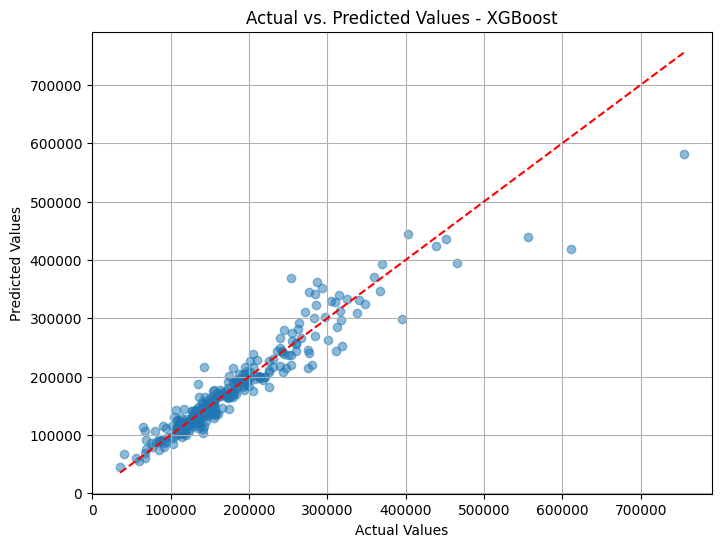

In [47]:
plt.figure(figsize=(8, 6))
plt.scatter(exponent_valid, exponent_pred, alpha=0.5)
plt.plot([min(exponent_valid), max(exponent_valid)], [min(exponent_valid), max(exponent_valid)], linestyle='--', color='r')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values - XGBoost")
plt.grid(True)
plt.show()

After trying out this set of steps, final result is close but lower than the first project.

NOTE: Project 2 was first tried without log transformation and results were noted. Later on it was tried with log transfromation and the results did not change significantly. Therefore it will not be apllied in further projects. 